In [30]:
import SimpleITK as sitk
import pandas as pd

%matplotlib notebook

import matplotlib.pyplot as plt
from math import ceil
from skimage.io import imread
from skimage import filters

In [31]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from matplotlib.widgets import  RectangleSelector
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import copy

def multi_image_display2D(image_list, title_list=None, window_level_list= None, figure_size=(10,8), horizontal=True):

    if title_list:
        if len(image_list)!=len(title_list):
            raise ValueError('Title list and image list lengths do not match')
    else:
        title_list = ['']*len(image_list)

    # Create a figure.
    col_num, row_num = (len(image_list), 1)  if horizontal else (1, len(image_list))
    fig, axes = plt.subplots(row_num, col_num, figsize=figure_size)
    if len(image_list)==1:
        axes = [axes]

    # Get images as numpy arrays for display and the window level settings
    npa_list = list(map(sitk.GetArrayViewFromImage, image_list))
    if not window_level_list:
        min_intensity_list = list(map(np.min, npa_list))
        max_intensity_list = list(map(np.max, npa_list))
    else:
        min_intensity_list = list(map(lambda x: x[1]-x[0]/2.0, window_level_list))
        max_intensity_list = list(map(lambda x: x[1]+x[0]/2.0, window_level_list))

    # Draw the image(s)
    for ax, npa, title, min_intensity, max_intensity in zip(axes, npa_list, title_list, min_intensity_list, max_intensity_list):
        ax.imshow(npa,
                  cmap=plt.cm.Greys_r,
                  vmin=min_intensity,
                  vmax=max_intensity)
        ax.set_title(title)
        ax.set_axis_off()
    fig.tight_layout()
    return (fig, axes)


class MultiImageDisplay(object):
    '''
    This class provides a GUI for displaying 3D images. It supports display of
    multiple images in the same UI. The image slices are selected according to
    the axis specified by the user. Each image can have a title and a slider to
    scroll through the stack. The images can also share a single slider if they
    have the same number of slices along the given axis. Images are either
    grayscale or color. The intensity range used for display (window-level) can
    be specified by the user as input to the constructor or set via the displayed
    slider. For color images the intensity control slider will be disabled. This
    allows us to display both color and grayscale images in the same figure with
    a consistent look to the controls. The range of the intensity slider is set
    to be from top/bottom 2% of intensities (accomodating for outliers). Images
    are displayed either in horizontal or vertical layout, depending on the
    users choice.
    '''
    def __init__(self, image_list, axis=0, shared_slider=False, title_list=None, window_level_list= None, intensity_slider_range_percentile = [2,98], figure_size=(10,8), horizontal=True):

        self.npa_list, wl_range, wl_init = self.get_window_level_numpy_array(image_list, window_level_list, intensity_slider_range_percentile)
        if title_list:
            if len(image_list)!=len(title_list):
                raise ValueError('Title list and image list lengths do not match')
            self.title_list = list(title_list)
        else:
            self.title_list = ['']*len(image_list)

        # Our dynamic slice, based on the axis the user specifies
        self.slc = [slice(None)]*3
        self.axis = axis

        ui = self.create_ui(shared_slider, wl_range, wl_init)
        display(ui)

        # Create a figure.
        col_num, row_num = (len(image_list), 1)  if horizontal else (1, len(image_list))
        self.fig, self.axes = plt.subplots(row_num,col_num,figsize=figure_size)
        if len(image_list)==1:
            self.axes = [self.axes]


        # Display the data and the controls, first time we display the image is outside the "update_display" method
        # as that method relies on the previous zoom factor which doesn't exist yet.
        for ax, npa, slider, wl_slider in zip(self.axes, self.npa_list, self.slider_list, self.wl_list):
            self.slc[self.axis] = slice(slider.value, slider.value+1)
            # Need to use squeeze to collapse degenerate dimension (e.g. RGB image size 124 124 1 3)
            ax.imshow(np.squeeze(npa[tuple(self.slc)]),
                      cmap=plt.cm.Greys_r,
                      vmin=wl_slider.value[0],
                      vmax=wl_slider.value[1])
        self.update_display()
        plt.tight_layout()


    def create_ui(self, shared_slider,wl_range, wl_init):
        # Create the active UI components. Height and width are specified in 'em' units. This is
        # a html size specification, size relative to current font size.

        if shared_slider:
            # Validate that all the images have the same size along the axis which we scroll through
            sz = self.npa_list[0].shape[self.axis]
            for npa in self.npa_list:
                if npa.shape[self.axis]!=sz:
                    raise ValueError('Not all images have the same size along the specified axis, cannot share slider.')

            slider = widgets.IntSlider(description='image slice:',
                                      min=0,
                                      max=sz-1,
                                      step=1,
                                      value = int((sz-1)/2),
                                      width='20em')
            slider.observe(self.on_slice_slider_value_change, names='value')
            self.slider_list = [slider]*len(self.npa_list)
            slicer_box = widgets.Box(padding=7, children=[slider])
        else:
            self.slider_list = []
            for npa in self.npa_list:
                slider = widgets.IntSlider(description='image slice:',
                                           min=0,
                                           max=npa.shape[self.axis]-1,
                                           step=1,
                                           value = int((npa.shape[self.axis]-1)/2),
                                           width='20em')
                slider.observe(self.on_slice_slider_value_change, names='value')
                self.slider_list.append(slider)
            slicer_box = widgets.Box(padding=7, children=self.slider_list)
        self.wl_list = []
        # Each image has a window-level slider, but it is disabled if the image
        # is a color image len(npa.shape)==4 . This allows us to display both
        # color and grayscale images in the same UI while retaining a reasonable
        # layout for the sliders.
        for r_values, i_values, npa in zip(wl_range, wl_init, self.npa_list):
            wl_range_slider = widgets.IntRangeSlider(description='intensity:',
                                              min=r_values[0],
                                              max=r_values[1],
                                              step=1,
                                              value = [i_values[0], i_values[1]],
                                              width='20em',
                                              disabled = len(npa.shape) == 4)
            wl_range_slider.observe(self.on_wl_slider_value_change, names='value')
            self.wl_list.append(wl_range_slider)
        wl_box = widgets.Box(padding=7, children=self.wl_list)
        return widgets.VBox(children=[slicer_box,wl_box])

    def get_window_level_numpy_array(self, image_list, window_level_list, intensity_slider_range_percentile):
        # Using GetArray and not GetArrayView because we don't keep references
        # to the original images. If they are deleted outside the view would become
        # invalid, so we use a copy wich guarentees that the gui is consistent.
        npa_list = list(map(sitk.GetArrayFromImage, image_list))

        wl_range = []
        wl_init = []
        # We need to iterate over the images because they can be a mix of
        # grayscale and color images. If they are color we set the wl_range
        # to [0,255] and the wl_init is equal, ignoring the window_level_list
        # entry.
        for i, npa in enumerate(npa_list):
            if len(npa.shape) == 4: #color image
                wl_range.append((0,255))
                wl_init.append((0,255))
                # ignore any window_level_list entry
            else:
                # We don't necessarily take the minimum/maximum values, just in case there are outliers
                # user can specify how much to take off from top and bottom.
                min_max = np.percentile(npa.flatten(), intensity_slider_range_percentile)
                wl_range.append((min_max[0], min_max[1]))
                if not window_level_list: # No list was given.
                    wl_init.append(wl_range[-1])
                else:
                    wl = window_level_list[i]
                    if wl:
                        wl_init.append((wl[1]-wl[0]/2.0, wl[1]+wl[0]/2.0))
                    else: # We have a list, but for this image the entry was left empty: []
                        wl_init.append(wl_range[-1])
        return (npa_list, wl_range, wl_init)

    def on_slice_slider_value_change(self, change):
        self.update_display()

    def on_wl_slider_value_change(self, change):
        self.update_display()

    def update_display(self):

        # Draw the image(s)
        for ax, npa, title, slider, wl_slider in zip(self.axes, self.npa_list, self.title_list, self.slider_list, self.wl_list):
            # We want to keep the zoom factor which was set prior to display, so we log it before
            # clearing the axes.
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()

            self.slc[self.axis] = slice(slider.value, slider.value+1)
            ax.clear()
            # Need to use squeeze to collapse degenerate dimension (e.g. RGB image size 124 124 1 3)
            ax.imshow(np.squeeze(npa[tuple(self.slc)]),
                      cmap=plt.cm.Greys_r,
                      vmin=wl_slider.value[0],
                      vmax=wl_slider.value[1])
            ax.set_title(title)
            ax.set_axis_off()

            # Set the zoom factor back to what it was before we cleared the axes, and rendered our data.
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

        self.fig.canvas.draw_idle()


In [68]:
img = imread('../data/sample1_02_25_21/tcells_dapi_lamina_hp1/Tcells_HP1_Lamin_DAPI_11.tif')
img = img[:,:,:,0]

<IPython.core.display.Javascript object>


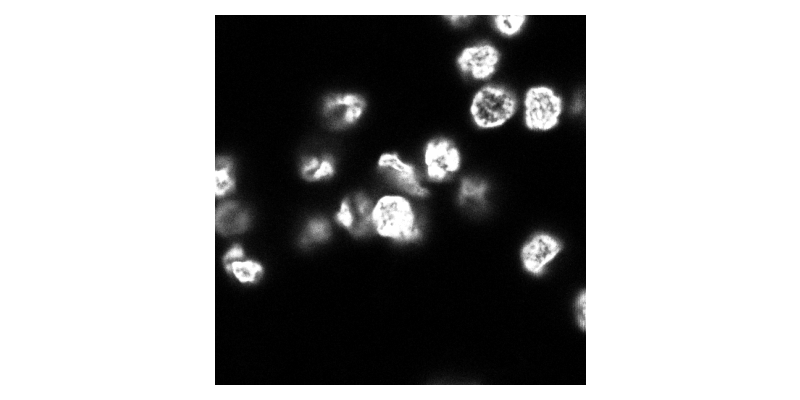

In [69]:
sitk_img = sitk.GetImageFromArray(img)
MultiImageDisplay(image_list = [sitk_img], figure_size=(8,4));

In [70]:
gaussian_filter = sitk.MedianImageFilter()
sitk_img = gaussian_filter.Execute(sitk_img)

<IPython.core.display.Javascript object>


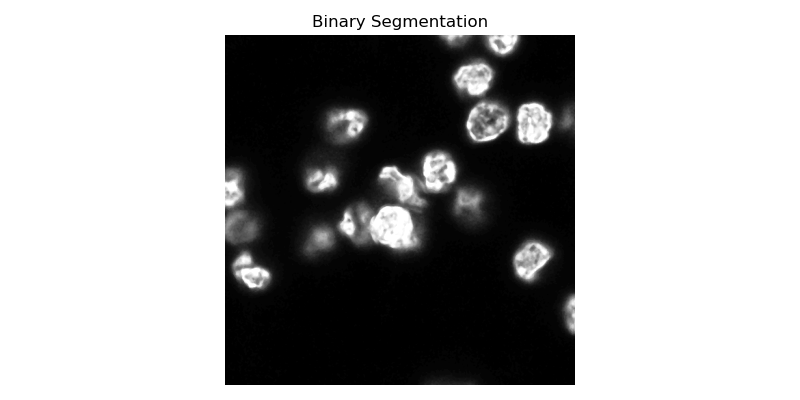

In [71]:
MultiImageDisplay(image_list = [sitk_img],                   
                      title_list = ['Binary Segmentation'], figure_size=(8,4));

Threshold used: 27.0


<IPython.core.display.Javascript object>


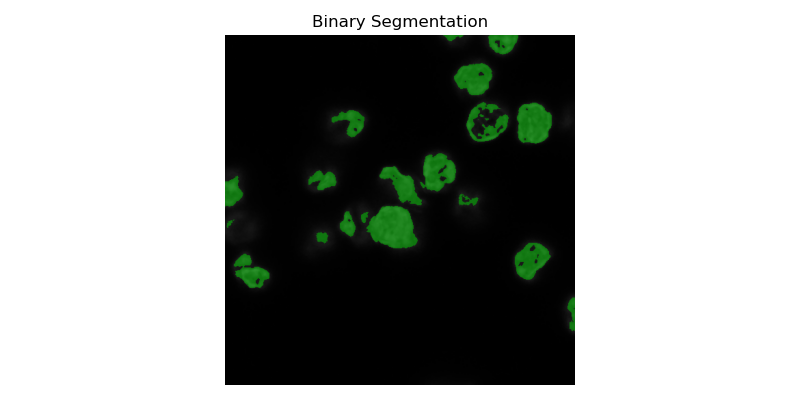

In [72]:
threshold_filters = {'Otsu': sitk.OtsuThresholdImageFilter(),
                     'Triangle' : sitk.TriangleThresholdImageFilter(),
                     'Huang' : sitk.HuangThresholdImageFilter(),
                     'MaxEntropy' : sitk.MaximumEntropyThresholdImageFilter()}

filter_selection = 'Otsu'
try:
    thresh_filter = threshold_filters[filter_selection]
    thresh_filter.SetInsideValue(0)
    thresh_filter.SetOutsideValue(1)
    thresh_img = thresh_filter.Execute(sitk_img)
    thresh_value = thresh_filter.GetThreshold()
except KeyError:
    thresh_value = 10
    thresh_img = img>thresh_value

print("Threshold used: " + str(thresh_value))    
MultiImageDisplay(image_list = [sitk.LabelOverlay(sitk_img, thresh_img)],                   
                      title_list = ['Binary Segmentation'], figure_size=(8,4));

<IPython.core.display.Javascript object>


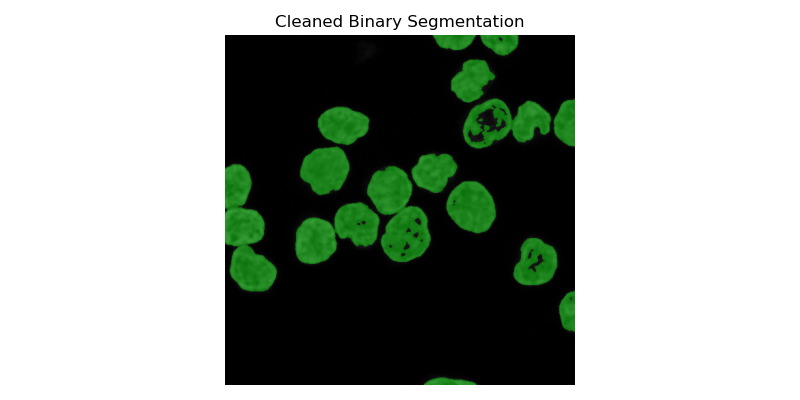

In [88]:
cleaned_thresh_img = sitk.BinaryOpeningByReconstruction(thresh_img, [1, 1, 1])
cleaned_thresh_img = sitk.BinaryClosingByReconstruction(cleaned_thresh_img, [1, 1, 1])

MultiImageDisplay(image_list = [sitk.LabelOverlay(sitk_img, cleaned_thresh_img)],                   
                      title_list = ['Cleaned Binary Segmentation'], figure_size=(8,4));

<IPython.core.display.Javascript object>


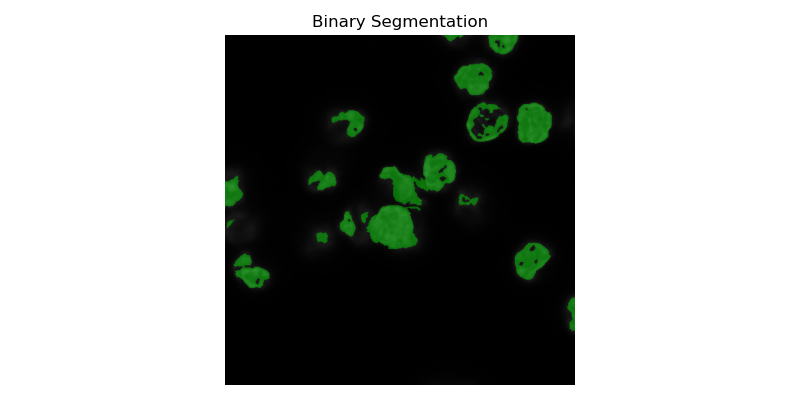

In [62]:
MultiImageDisplay(image_list = [sitk.LabelOverlay(sitk_img, thresh_img)],                   
                      title_list = ['Binary Segmentation'], figure_size=(8,4));